In [15]:
from google.colab import drive
from sentence_transformers import SentenceTransformer

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!pip install chromadb
# #

In [17]:
# !pip install fitz

In [18]:
!pip install PyMuPDF

In [19]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    """Extract text from an uploaded PDF file"""
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text() for page in doc])
    return text

# Example usage:
pdf_path = "/content/drive/MyDrive/Colab Notebooks/data/1_2972855.pdf"
document_text = extract_text_from_pdf(pdf_path)
print(document_text[:5000])  # Print first 1000 characters for checking


 
 
SLAVE TO THE ALGORITHM? WHY A ‘RIGHT 
TO AN EXPLANATION’ IS PROBABLY NOT THE 
REMEDY YOU ARE LOOKING FOR 
LILIAN EDWARDS† & MICHAEL VEALE†† 
ABSTRACT 
Algorithms, particularly machine learning (ML) algorithms, 
are increasingly important to individuals’ lives, but have caused a 
range of concerns revolving mainly around unfairness, 
discrimination and opacity. Transparency in the form of a “right to 
an explanation” has emerged as a compellingly attractive remedy 
since it intuitively promises to open the algorithmic “black box” to 
promote 
challenge, 
redress, 
and 
hopefully 
heightened 
accountability. Amidst the general furore over algorithmic bias we 
describe, any remedy in a storm has looked attractive. 
However, we argue that a right to an explanation in the EU 
General Data Protection Regulation (GDPR) is unlikely to present 
a complete remedy to algorithmic harms, particularly in some of 
the core “algorithmic war stories” that have shaped recent 
attitudes in this domai

In [20]:
!pip install -U langchain-community

In [21]:
# !pip install sentence-transformers

In [29]:
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from transformers import pipeline

def rag_summary(user_query, document_text):
    ### 1️⃣ Load and Split Document ###
    def load_and_split_document(text, chunk_size=512, chunk_overlap=50):
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap
        )
        return splitter.split_text(text)

    ### 2️⃣ Store Document in ChromaDB ###
    def store_document_in_chromadb(chroma_db, document_chunks):
        for i, chunk in enumerate(document_chunks):
            chroma_db.add_texts(texts=[chunk], metadatas=[{"chunk_id": i}])

    ### 3️⃣ Retrieve Relevant Chunks from ChromaDB ###
    def retrieve_relevant_chunks(chroma_db, query, k=10):
        return chroma_db.similarity_search(query, k=k)

    ### 4️⃣ Summarize Retrieved Chunks ###
    def summarize_text(query, text):
        summarizer = pipeline("summarization", model="t5-base")
        input_text = f"Query: {query} \nDocument: {text}"  # 🔥 Query-based input
        summary = summarizer(input_text, max_length=150, min_length=50, do_sample=False)
        return summary[0]['summary_text']

    ### 🚀 RAG Summarization Pipeline ###
    def rag_summarization(chroma_db, query):
        retrieved_chunks = retrieve_relevant_chunks(chroma_db, query)

        # Combine retrieved chunks
        retrieved_text = " ".join([chunk.page_content for chunk in retrieved_chunks if len(chunk.page_content.split()) > 5])

        if not retrieved_text:
            return "No relevant content found for summarization."

        return summarize_text(query, retrieved_text)

    ### ⚡ Pipeline Execution ###
    embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    chroma_db = Chroma(persist_directory="/content/drive/MyDrive/VectorDB_Embeddings", embedding_function=embedding_function)

    # Step 1: Split document into chunks
    document_chunks = load_and_split_document(document_text)

    # Step 2: Store in ChromaDB
    store_document_in_chromadb(chroma_db, document_chunks)

    # Step 3: Perform Query-Based Summarization
    summary = rag_summarization(chroma_db, user_query)

    print("Summary:", summary)
    return summary



In [23]:
from transformers import pipeline

def t5small_summary(query, document_text):

  # Initialize T5-Small summarization model
  t5_summarizer = pipeline("summarization", model="t5-small")

  ### Function to Summarize Text in Chunks ###
  def chunked_t5_summarization(query, text, chunk_size=256, max_chunks=15, max_length=100, min_length=30):
      chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)][:max_chunks]  # Limit to 15 chunks
      summaries = []

      for chunk in chunks:
          input_text = f"Query: {query} \nDocument: {chunk}"
          summary = t5_summarizer(input_text, max_length=max_length, min_length=min_length, do_sample=False)
          summaries.append(summary[0]['summary_text'])

      return " ".join(summaries)  # Combine chunk summaries into final summary

  t5_query_summary = chunked_t5_summarization(query, document_text)
  return t5_query_summary

In [24]:
!pip install rouge-score


In [25]:
# test on one file
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import time

client = chromadb.PersistentClient(path="/content/drive/MyDrive/VectorDB_Embeddings")
collection = client.get_or_create_collection(name='ties_collection_emb', metadata={"hnsw:space": "cosine"})
def rag_query(query):
    """Retrieves the most relevant document chunks from the vector database."""
    results = collection.query(query_texts=[query], n_results=3)

    if "documents" not in results or not results["documents"]:
        return []

    retrieved_docs = results["documents"][0]  # List of relevant chunk texts

    # Convert to document-like objects
    class Document:
        def __init__(self, content):
            self.page_content = content

    return [Document(doc) for doc in retrieved_docs]

# ------------------------------------------------------------------------------

# Folder path containing PDFs
pdf = "/content/drive/MyDrive/Colab Notebooks/data/38_1612851.pdf"

# Load your models


# Extract text from the first 1000 characters (approx. abstract)
def extract_abstract(pdf_path):
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text("text") for page in doc])
    return text[:1000]  # First 1000 chars as ground truth summary

# Compute BLEU score
def compute_bleu(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    return sentence_bleu(reference_tokens, candidate_tokens)

# Compute ROUGE scores
def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)

# Find all PDFs in the folder
# pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

# Evaluate on all PDFs
# Store results
bleu_scores = {"RAG": [], "t5small": []}
rouge_scores = {"RAG": {"rouge1": [], "rouge2": [], "rougeL": []},
                "t5small": {"rouge1": [], "rouge2": [], "rougeL": []}}

# Evaluation loop
# for pdf in pdf_files:
print(f"Processing {pdf}...")

# Extract reference summary
reference_summary = extract_abstract(pdf)

# summary generation
query = "Summarize this paper in 200 words."
rag_summary = rag_summary(query, document_text)
t5small_summary_text = t5small_summary(query, document_text)

# Compute BLEU & ROUGE
bleu_rag = compute_bleu(reference_summary, rag_summary)
rouge_rag = compute_rouge(reference_summary, rag_summary)

bleu_t5small = compute_bleu(reference_summary, t5small_summary_text)
rouge_t5small = compute_rouge(reference_summary, t5small_summary_text)

# Store results
bleu_scores["RAG"].append(bleu_rag)
bleu_scores["t5small"].append(bleu_t5small)

for key in ["rouge1", "rouge2", "rougeL"]:
    rouge_scores["RAG"][key].append(rouge_rag[key].fmeasure)
    rouge_scores["t5small"][key].append(rouge_t5small[key].fmeasure)

rag_query(query)
time.sleep(2)

# # Print final evaluation results
# for model, scores in results.items():
#     avg_bleu = sum(s["BLEU"] for s in scores) / len(scores)
#     avg_rouge1 = sum(s["ROUGE"]["rouge1"].fmeasure for s in scores) / len(scores)
#     avg_rouge2 = sum(s["ROUGE"]["rouge2"].fmeasure for s in scores) / len(scores)
#     avg_rougeL = sum(s["ROUGE"]["rougeL"].fmeasure for s in scores) / len(scores)

#     print(f"\n🔷 {model} Performance:")
#     print(f"   🟢 Avg BLEU: {avg_bleu:.4f}")
#     print(f"   🟢 Avg ROUGE-1: {avg_rouge1:.4f}")
#     print(f"   🟢 Avg ROUGE-2: {avg_rouge2:.4f}")
#     print(f"   🟢 Avg ROUGE-L: {avg_rougeL:.4f}")

# Compute and print final evaluation results
avg_bleu_rag = sum(bleu_scores["RAG"]) / len(bleu_scores["RAG"])
avg_bleu_t5small = sum(bleu_scores["t5small"]) / len(bleu_scores["t5small"])

avg_rouge_rag = {key: sum(rouge_scores["RAG"][key]) / len(rouge_scores["RAG"][key]) for key in ["rouge1", "rouge2", "rougeL"]}
avg_rouge_t5small = {key: sum(rouge_scores["t5small"][key]) / len(rouge_scores["t5small"][key]) for key in ["rouge1", "rouge2", "rougeL"]}

# Print results for RAG model
print("\n🔷 RAG Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_rag:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_rag['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_rag['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_rag['rougeL']:.4f}")

# Print results for T5-small model
print("\n🔷 T5-Small Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_t5small:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_t5small['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_t5small['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_t5small['rougeL']:.4f}")



Processing /content/drive/MyDrive/Colab Notebooks/data/38_1612851.pdf...


Device set to use cpu


Summary: electronic copy available at: https://ssrn.com/abstract=2972855 ENHANCING TECHNOLOGIES (Springer 2012). Electronic copy available . at: http://www.ec.gc.ca/papers/enhancing-technology/index.html .


Device set to use cpu
Your max_length is set to 100, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 100, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 100, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 100, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...


🔷 RAG Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1677
   🟢 Avg ROUGE-2: 0.1333
   🟢 Avg ROUGE-L: 0.1557

🔷 T5-Small Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.2153
   🟢 Avg ROUGE-2: 0.0707
   🟢 Avg ROUGE-L: 0.1252


In [26]:
# Compute and print final evaluation results
avg_bleu_rag = sum(bleu_scores["RAG"]) / len(bleu_scores["RAG"])
avg_bleu_t5small = sum(bleu_scores["t5small"]) / len(bleu_scores["t5small"])

avg_rouge_rag = {key: sum(rouge_scores["RAG"][key]) / len(rouge_scores["RAG"][key]) for key in ["rouge1", "rouge2", "rougeL"]}
avg_rouge_t5small = {key: sum(rouge_scores["t5small"][key]) / len(rouge_scores["t5small"][key]) for key in ["rouge1", "rouge2", "rougeL"]}

# Print results for RAG model
print("\n🔷 classical RAG Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_rag:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_rag['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_rag['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_rag['rougeL']:.4f}")

# Print results for T5-small model
print("\n🔷 T5-Small Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_t5small:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_t5small['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_t5small['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_t5small['rougeL']:.4f}")



🔷 classical RAG Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1677
   🟢 Avg ROUGE-2: 0.1333
   🟢 Avg ROUGE-L: 0.1557

🔷 T5-Small Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.2153
   🟢 Avg ROUGE-2: 0.0707
   🟢 Avg ROUGE-L: 0.1252


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


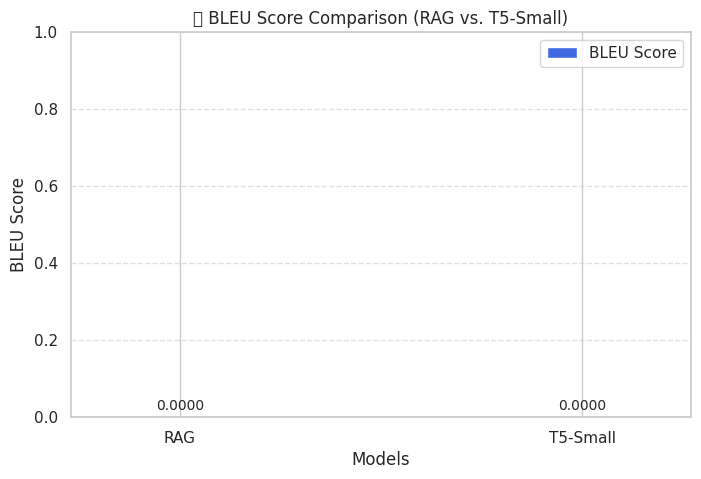

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


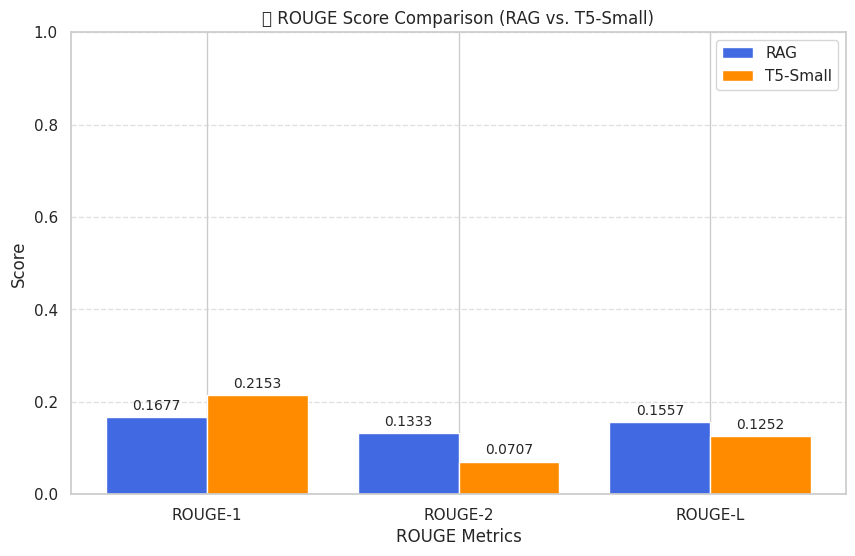

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# Data for BLEU scores
models = ["RAG", "T5-Small"]
bleu_scores_avg = [avg_bleu_rag, avg_bleu_t5small]

# Convert categorical x-axis to numerical indices
x_bleu = np.arange(len(models))
width = 0.4

# Create BLEU Score Bar Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars_bleu = ax.bar(x_bleu, bleu_scores_avg, width, color=["royalblue", "orangered"], label="BLEU Score")

# Labels and title
ax.set_xlabel("Models")
ax.set_ylabel("BLEU Score")
ax.set_title("🔹 BLEU Score Comparison (RAG vs. T5-Small)")
ax.set_xticks(x_bleu)
ax.set_xticklabels(models)

# Display values on bars
for bar in bars_bleu:
    height = bar.get_height()
    ax.annotate(f"{height:.4f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend()
plt.show()


# Data for ROUGE scores
rouge_metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
rag_rouge_scores = [avg_rouge_rag["rouge1"], avg_rouge_rag["rouge2"], avg_rouge_rag["rougeL"]]
t5small_rouge_scores = [avg_rouge_t5small["rouge1"], avg_rouge_t5small["rouge2"], avg_rouge_t5small["rougeL"]]

x_rouge = np.arange(len(rouge_metrics))

# Create ROUGE Score Comparison Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x_rouge - width/2, rag_rouge_scores, width, label="RAG", color="royalblue")
bars2 = ax.bar(x_rouge + width/2, t5small_rouge_scores, width, label="T5-Small", color="darkorange")

# Labels and title
ax.set_xlabel("ROUGE Metrics")
ax.set_ylabel("Score")
ax.set_title("🔹 ROUGE Score Comparison (RAG vs. T5-Small)")
ax.set_xticks(x_rouge)
ax.set_xticklabels(rouge_metrics)
ax.legend()

# Display values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.4f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()


In [31]:
# test on many files
import os
import glob
import time
import fitz  # PyMuPDF
import chromadb
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Initialize ChromaDB client
client = chromadb.PersistentClient(path="/content/drive/MyDrive/VectorDB_Embeddings")
collection = client.get_or_create_collection(name='ties_collection_emb', metadata={"hnsw:space": "cosine"})

def rag_query(query):
    """Retrieves the most relevant document chunks from the vector database."""
    results = collection.query(query_texts=[query], n_results=3)
    if "documents" not in results or not results["documents"]:
        return []
    return results["documents"][0]  # List of relevant chunk texts

def extract_text_from_pdf(pdf_path):
    """Extracts text from a PDF file."""
    doc = fitz.open(pdf_path)
    return "\n".join([page.get_text("text") for page in doc])

def extract_abstract(pdf_path):
    """Extracts the first 1000 characters as the ground truth summary."""
    text = extract_text_from_pdf(pdf_path)
    return text[:1000] if text else ""

def compute_bleu(reference, candidate):
    """Computes BLEU score between reference and candidate summaries."""
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()
    return sentence_bleu(reference_tokens, candidate_tokens)

def compute_rouge(reference, candidate):
    """Computes ROUGE scores."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)

# Directory containing PDFs
pdf_folder = "/content/drive/MyDrive/Colab Notebooks/data/"
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

# Dictionaries to store scores
bleu_scores = {"RAG": [], "T5-Small": []}
rouge_scores = {"RAG": {"rouge1": [], "rouge2": [], "rougeL": []},
                "T5-Small": {"rouge1": [], "rouge2": [], "rougeL": []}}

# Process each PDF file
for pdf in pdf_files:
    print(f"\n🔹 Processing {pdf}...")

    # Extract reference summary
    reference_summary = extract_abstract(pdf)
    if not reference_summary:
        print(f"⚠️ Skipping {pdf} (no extractable text).")
        continue

    # Retrieve document context using RAG
    query = "Summarize this paper in 200 words."
    retrieved_docs = rag_query(query)
    document_text = " ".join(retrieved_docs) if retrieved_docs else ""

    # Generate summaries using RAG and T5-Small
    rag_summary_text = rag_summary(query, document_text)
    t5small_summary_text = t5small_summary(query, document_text)

    # Compute BLEU & ROUGE scores
    bleu_rag = compute_bleu(reference_summary, rag_summary_text)
    rouge_rag = compute_rouge(reference_summary, rag_summary_text)

    bleu_t5small = compute_bleu(reference_summary, t5small_summary_text)
    rouge_t5small = compute_rouge(reference_summary, t5small_summary_text)

    # Store results
    bleu_scores["RAG"].append(bleu_rag)
    bleu_scores["T5-Small"].append(bleu_t5small)

    for key in ["rouge1", "rouge2", "rougeL"]:
        rouge_scores["RAG"][key].append(rouge_rag[key].fmeasure)
        rouge_scores["T5-Small"][key].append(rouge_t5small[key].fmeasure)

    # Pause to avoid rate limits
    time.sleep(2)

# Compute final average scores
avg_bleu_rag = sum(bleu_scores["RAG"]) / len(bleu_scores["RAG"])
avg_bleu_t5small = sum(bleu_scores["T5-Small"]) / len(bleu_scores["T5-Small"])

avg_rouge_rag = {key: sum(rouge_scores["RAG"][key]) / len(rouge_scores["RAG"][key]) for key in ["rouge1", "rouge2", "rougeL"]}
avg_rouge_t5small = {key: sum(rouge_scores["T5-Small"][key]) / len(rouge_scores["T5-Small"][key]) for key in ["rouge1", "rouge2", "rougeL"]}

# Print final results
print("\n🔷 RAG Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_rag:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_rag['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_rag['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_rag['rougeL']:.4f}")

print("\n🔷 T5-Small Model Performance:")
print(f"   🟢 Avg BLEU: {avg_bleu_t5small:.4f}")
print(f"   🟢 Avg ROUGE-1: {avg_rouge_t5small['rouge1']:.4f}")
print(f"   🟢 Avg ROUGE-2: {avg_rouge_t5small['rouge2']:.4f}")
print(f"   🟢 Avg ROUGE-L: {avg_rouge_t5small['rougeL']:.4f}")



🔹 Processing /content/drive/MyDrive/Colab Notebooks/data/10_2202843.pdf...


Device set to use cpu


Summary: electronic copy available at: https://ssrn.com/abstract=2972855 ENHANCING TECHNOLOGIES (Springer 2012). e.g., it seems quite possible to view the reference to Article 22 as merely instantiating one form of automated decision making .


Device set to use cpu
Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 100, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 100, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...


🔹 Processing /content/drive/MyDrive/Colab Notebooks/data/10_2765268.pdf...


Device set to use cpu


Summary: electronic copy available at: https://ssrn.com/abstract=2972855 ENHANCING TECHNOLOGIES (Springer 2012). e.g., it seems quite possible to view the reference to Article 22 as merely instantiating one form of automated decision making .


Device set to use cpu
Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 100, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 100, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...


🔹 Processing /content/drive/MyDrive/Colab Notebooks/data/13_1108671.pdf...


Device set to use cpu


Summary: electronic copy available at: https://ssrn.com/abstract=2972855 ENHANCING TECHNOLOGIES (Springer 2012). e.g., it seems quite possible to view the reference to Article 22 as merely instantiating one form of automated decision making .


Device set to use cpu
Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 100, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 100, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...


🔹 Processing /content/drive/MyDrive/Colab Notebooks/data/38_1612851.pdf...


Device set to use cpu


Summary: electronic copy available at: https://ssrn.com/abstract=2972855 ENHANCING TECHNOLOGIES (Springer 2012). e.g., it seems quite possible to view the reference to Article 22 as merely instantiating one form of automated decision making .


Device set to use cpu
Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 100, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 100, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 100, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...


🔷 RAG Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1226
   🟢 Avg ROUGE-2: 0.0593
   🟢 Avg ROUGE-L: 0.0952

🔷 T5-Small Model Performance:
   🟢 Avg BLEU: 0.0000
   🟢 Avg ROUGE-1: 0.1629
   🟢 Avg ROUGE-2: 0.0450
   🟢 Avg ROUGE-L: 0.1124
